# Linear Regression and Price Analysis using Random Forest



In [32]:
# Load necessary libraries
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns
from matplotlib import gridspec
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

sns.set()

In [33]:
secondary = pd.read_csv('../dataset/secondary.csv', sep=",")
general_data = pd.DataFrame(secondary)
general_data.head()

,cardFinish,gameAvailability,price,priceProvider,providerListing,uuid,artist,colorIdentity,colors,edhrecRank,...,name,number,originalType,power,rarity,setCode,supertypes,toughness,type,types
0,normal,mtgo,0.03,cardhoarder,retail,29924ca8-4937-5caa-a972-489bf1fd5139,Mark Tedin,U,U,10512.0,...,Braingeyser,205,NaN,NaN,rare,PRM,NaN,NaN,Sorcery,Sorcery
1,normal,mtgo,0.17,cardhoarder,retail,aa0bf97b-807d-5fdd-a73d-26221d4d10f0,Amy Weber,R,R,6705.0,...,Fork,207,NaN,NaN,rare,PRM,NaN,NaN,Instant,Instant
2,normal,mtgo,0.03,cardhoarder,retail,f9e61d2d-bed5-5eb8-a876-5537572da8aa,Jesper Myrfors,G,G,25046.0,...,Ifh-Bíff Efreet,213,NaN,3,rare,PRM,NaN,3,Creature — Efreet,Creature
3,normal,mtgo,0.03,cardhoarder,retail,817fcaad-58b5-5580-a996-969b2183c837,Douglas Shuler,B,B,23391.0,...,Khabál Ghoul,215,NaN,1,rare,PRM,NaN,1,Creature — Zombie,Creature
4,normal,mtgo,0.05,cardhoarder,retail,dc3aff87-5063-5969-84de-db0770b7d199,Sandra Everingham,C,C,1337.0,...,Zuran Orb,225,NaN,NaN,uncommon,PRM,NaN,NaN,Artifact,Artifact


In [57]:

# Using information from secondary.csv instead of original data merging

mapped_data = general_data.select_dtypes(include=['number'])

label_encoder = LabelEncoder()

# one-hot categorical data for general analysis
to_encode = ['rarity', 'artist', 'cardFinish', 'supertypes',
             'gameAvailability', 'priceProvider', 'setCode', 'type']
for enc in to_encode:    
    mapped_data[enc] = label_encoder.fit_transform(general_data[enc])

mapped_data.columns

Index(['price', 'edhrecRank', 'edhrecSaltiness', 'isReprint', 'manaValue',
       'rarity', 'artist', 'cardFinish', 'supertypes', 'gameAvailability',
       'priceProvider', 'setCode', 'type'],
      dtype='object')

In [35]:
# Update mapped file
mapped_data.to_csv('../dataset/mapped_data.csv', index=False)
mapped_data.head()

,price,edhrecRank,edhrecSaltiness,isReprint,manaValue,rarity,artist,cardFinish,supertypes,gameAvailability,priceProvider,setCode,type
0,0.03,10512.0,0.44,1,2.0,3,858,2,4,0,0,424,2088
1,0.17,6705.0,0.50,1,2.0,3,57,2,4,0,0,424,1390
2,0.03,25046.0,0.25,1,4.0,3,608,2,4,0,0,424,373
3,0.03,23391.0,0.33,1,3.0,3,353,2,4,0,0,424,1263
4,0.05,1337.0,0.24,1,0.0,5,1168,2,4,0,0,424,0


In [58]:
# Remove outliers to anbalyze prices
def removeOutliers(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
 
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    outlier_free_list = [x for x in data[col] if ((x > lower_range) & (x < upper_range))]
    filtered_data = data.loc[data[col].isin(outlier_free_list)]
    return filtered_data

mapped_data = removeOutliers(mapped_data, 'price')


In [59]:
import statsmodels.api as sm

X = mapped_data.loc[:, ~mapped_data.columns.isin(['price'])]
y = mapped_data["price"]

model = sm.OLS(y, X)    # Describe model

result = model.fit()       # Fit model

print(result.summary()) 

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.472
Model:                            OLS   Adj. R-squared (uncentered):              0.472
Method:                 Least Squares   F-statistic:                          1.701e+04
Date:                Fri, 11 Oct 2024   Prob (F-statistic):                        0.00
Time:                        09:30:20   Log-Likelihood:                     -3.0244e+05
No. Observations:              228637   AIC:                                  6.049e+05
Df Residuals:                  228625   BIC:                                  6.050e+05
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [49]:
from sklearn.metrics import mean_squared_error

y_pred = result.predict(X)
mse = mean_squared_error(y, y_pred)

fstat, pvalue = sm.stats.linear_rainbow(result)
print(f' f stat: {fstat} | p value: {pvalue} | mse: {mse}')

 f stat: 1.1854226824704048 | p value: 6.396458748019451e-182 | mse: 0.8250364187896078


---

# Linear Regression Prediction

In [51]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression model and use it based on selected feature and target
def prediction(feature, target):
    X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=42)
    
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    model = LinearRegression().fit(X_train_poly, y_train)
    
    y_pred = model.predict(X_test_poly)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return y_test, y_pred, mse, r2

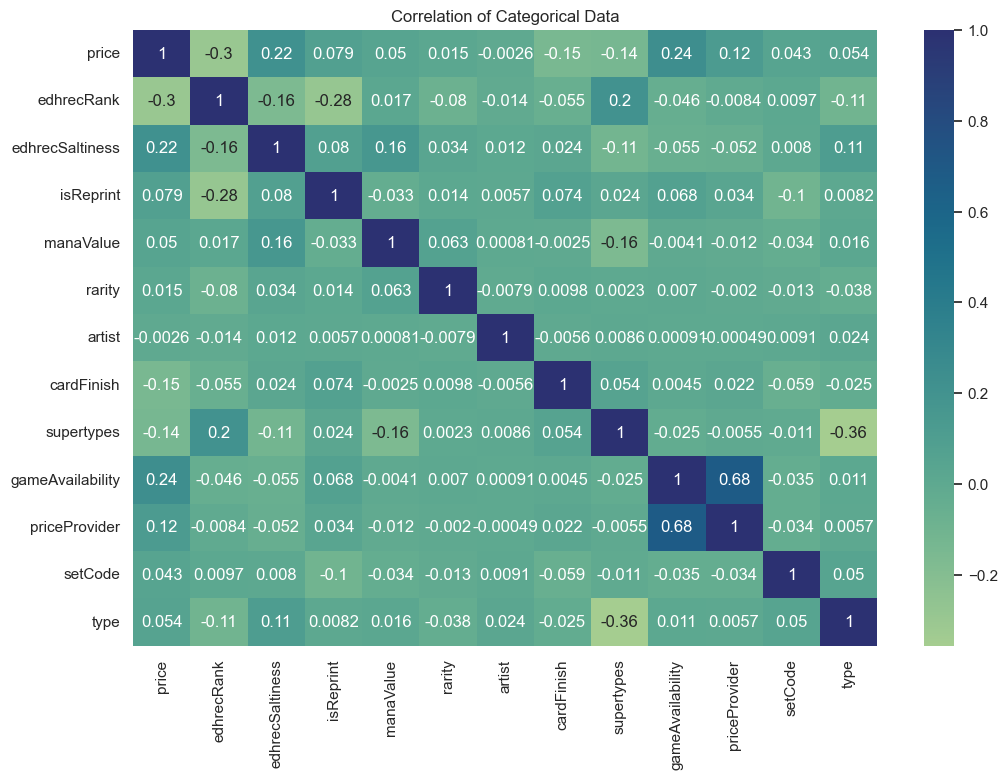

In [52]:

plt.figure(figsize=(12,8))
sns.heatmap(mapped_data.corr(),annot=True, cmap="crest")
plt.title("Correlation of Categorical Data")
plt.show()

Mean Squared Error: 0.7078715530930231
R-squared: 0.2961914559521318


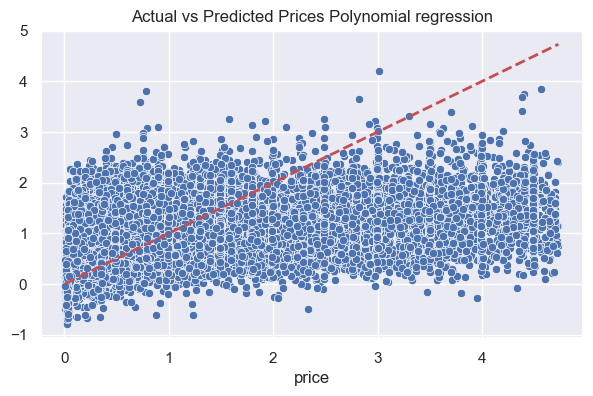

In [64]:
import statsmodels.api as sm
# Price Prediction based on Rank

X = mapped_data.loc[:, ~mapped_data.columns.isin(['price'])]
y = mapped_data["price"]

# Polinomial Linear Regression
y_test, y_pred, mse, r2 = prediction(X, y)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Ploting results

plt.figure(figsize=(7,4))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'Actual vs Predicted Prices Polynomial regression')
plt.show()

---

# Random Forest implementation


In [54]:
# Random Forest implementation

# Modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import utils

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [55]:

# define features
X = mapped_data.loc[:, ~mapped_data.columns.isin(['price'])]
#convert y values to categorical values
y = mapped_data["price"]


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train_scaled, y_train)


Mean Squared Error: 0.44447611908414913
R-squared: 0.5579782292455684
             feature  importance
0         edhrecRank    0.238135
10           setCode    0.148425
1    edhrecSaltiness    0.130029
5             artist    0.107521
11              type    0.078571
4             rarity    0.076967
9      priceProvider    0.065886
3          manaValue    0.048944
6         cardFinish    0.040310
8   gameAvailability    0.039659
2          isReprint    0.018339
7         supertypes    0.007213


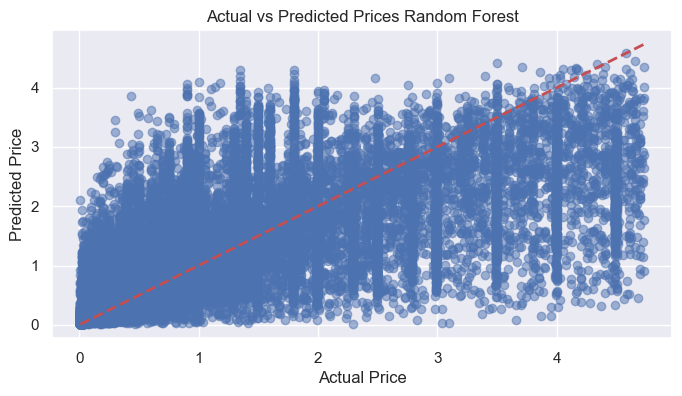

In [56]:

# Make predictions
y_pred = rf.predict(X_test_scaled)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Feature importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print(feature_importance)


# Visualize actual vs predicted prices
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices Random Forest')
plt.show()
